# Log
* Written by: Monib Sediqi
* Email: kh.monib@gmail.com
* Date: 12 Jul 2022

---

# Code Desc

* Binary classification and Class Activation Map (CAM) visualization

* Normality and abnormality detection of the following classes in a chest x-ray images.
1. Rib fracture
2. Pneumothorax
3. Tension pneumothorax
4. Hemothorax
5. Pericardial effusion
6. Mediastinum abnormality
7. Pleural effusion

* Input: X-ray image (1024x1024x3)
* Outputs:
    1. Probability score
    2. PNG image with CAM

* Network: XceptionNet
---

In [1]:
import tensorflow as tf
from tensorflow import keras

if tf.__version__ < '2.3.0':
    from tensorflow.python.keras import layers
else:
    from tensorflow.python.keras.layers import VersionAwareLayers

    layers = VersionAwareLayers()
import os
from IPython.display import Image, display
import matplotlib.cm as cm

try:
    import cv2
except:
    pass
import tensorflow as tf
import tqdm
from PIL import Image as PIL_Image

from skimage.transform import resize
import pydicom
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
tf.config.set_visible_devices(gpus[1], 'GPU') # using GPU2

2022-07-12 16:51:04.192421: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


2022-07-12 16:51:07.321264: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-07-12 16:51:07.416252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:19:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-07-12 16:51:07.417468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:1a:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-07-12 16:51:07.418615: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:67:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 8

# Clean data

In [2]:
class XrayData:
    def __init__(self, root_path = None, img_dir = None, label_dir = None, column_name = None):
        """
        root_path: (str) the path to root dirctory
        img_dir_name: (str) directory name to imagee
        label_dir : (str) directory name to labels. The labels can be in exel format
        column : (str) column to read data from excel file. For example = Rib Fracture
        """
        self.root_path = root_path
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.column_name = column_name
        self.data_dict = {"serial_no": [], column_name: [], 'x_ray_paths': []}
        # self.x_ray_paths = []

    def clean_labels(self, debug ='off'):

        excel_file = os.path.join(self.root_path, self.label_dir)
        data = pd.read_excel(excel_file)
        df = pd.DataFrame(data, columns=['Serial No', self.column_name])
        df = df.reset_index()

        for index, row in df.iterrows():
            if row["Serial No"] == row["Serial No"]:  # checking for NaN value
                self.data_dict["serial_no"].append(int(row["Serial No"]))
            if row[self.column_name] == 0 or row[self.column_name] == 1:
                self.data_dict[self.column_name].append(int(row[self.column_name]))
        assert len(self.data_dict["serial_no"]) == len(self.data_dict[self.column_name])
        print("cleaned up labels")

    def get_data(self):
        """
        Returns:
            dict: a dictionary of image paths with corresponding label
        """
        self.clean_labels()
        data_root = os.path.join(self.root_path, self.img_dir)

        for i in range(len(self.data_dict['serial_no'])):
            sub_path1 = os.path.join(data_root, str(self.data_dict["serial_no"][i]))
            dir_l1 = os.listdir(sub_path1)
            sub_path2 = os.path.join(sub_path1, dir_l1[0])
            # print("sub_path2", sub_path2)
            is_file = os.listdir(sub_path2)
            if len(is_file) != 0:
                # print('is file', is_file[0])
                if is_file[0].endswith('.dcm') or is_file[0].endswith('.DCM'):
                    self.data_dict['x_ray_paths'].append(os.path.join(sub_path2, is_file[0]))

                else:
                    sub_path3 = os.path.join(sub_path2, is_file[0])
                    # print("sub path3", sub_path3)
                    this_is_file = os.listdir(sub_path3)
                    if this_is_file[0].endswith(".dcm") or this_is_file[0].endswith('.DCM'):
                        self.data_dict['x_ray_paths'].append(os.path.join(sub_path3, this_is_file[0]))
                    else:
                        print("not a dicom file path:", os.path.join(sub_path3, this_is_file[0]))
        return self.data_dict

# Preprocess

In [3]:
# Preprocess the x_ray data
class Preprocesser:

    def __init__(self, method='min-max', scale_factor=1):
        """
            method : Normalization method
                - 'min-max' : min-max normalization
                - 'z-score' : z-score standardization
        """
        self.method = method
        self.scale_factor = scale_factor
    def normalize(self, image):

        if self.method == 'min-max':
            max_val = np.max(image)
            min_val = np.min(image)

            rescale_slope = max_val - min_val + 1e-13
            rescale_intercept = min_val

            image_norm = (image - rescale_intercept) / rescale_slope

        elif self.method == 'z-score':
            mean_val = np.mean(image)
            std_val = np.std(image)

            rescale_slope = std_val + 1e-13
            rescale_intercept = mean_val

            image_norm = (image - rescale_intercept) / rescale_slope

        else:
            rescale_slope = 1
            rescale_intercept = 0

            image_norm = (image - rescale_intercept) / rescale_slope
        return image_norm, rescale_intercept, rescale_slope

    def resize(self, image , new_size = None):

        return resize(image, new_size)


In [4]:
save_path = "/media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/rgb_files_600"
val_save_path = "/media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/val_split"
preprocessor = Preprocesser('min-max')

root_path = "/media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh"


def load_data(root_path):
    x_ray_1= XrayData(root_path=root_path, img_dir = "DICOM 파일 이신애", label_dir="Chest x-ray data - sort.xlsx", column_name="Pleural effusion")

    return [x_ray_1.get_data()]


img_h = 1024
img_w = 1024
num_ch = 3

def data2numpy(root_path):

    data = load_data(root_path)
    normal_images = []
    normal_labels = []
    abnormal_images = []
    abnormal_labels = []

    #printing a few paths with corresponding serial number and labels
    print(len(data[0]['x_ray_paths']))
    for i in range(len(data[0]['x_ray_paths'])):

        try:
            # if data[0]['Rib fracture'][i] == 1 or data[1]['Pneumothorax'][i] == 1 or data[2]['Tension pneumothorax'][i] ==1 or data[3]['Hemothorax'][i]==1 or data[4]['Pericardial effusion'][i] ==1 or data[5]['Mediastinum abnormality'][i] ==1 or data[6]['Pleural effusion'][i] ==1:
            if data[0]['Pleural effusion'][i] == 1:
                img_arr = pydicom.dcmread(data[0]['x_ray_paths'][i]).pixel_array # has shape x,y
                img_norm, _, _ = preprocessor.normalize(img_arr)

                img_resized = preprocessor.resize(img_norm, (img_h, img_w))
                img_resized = np.stack((img_resized,)*3, axis=-1)

                abnormal_images.append(img_resized)
                abnormal_labels.append(np.array(1))
            # label = data['Rib fracture'][i]
            else:
                print("path", data[0]['x_ray_paths'][i])
                img_arr = pydicom.dcmread(data[0]['x_ray_paths'][i]).pixel_array # has shape x,y
                img_norm, _, _ = preprocessor.normalize(img_arr)

                img_resized = preprocessor.resize(img_norm, (img_h, img_w))
                img_resized = np.stack((img_resized,)*3, axis=-1)

                normal_images.append(img_resized)
                normal_labels.append(np.array(0))

        except ValueError as ve:
            print(f"Value error at: {data[0]['x_ray_paths'][i]}")
            # error_paths.append(data['x_ray_paths'][i])

    # -------------- Perform on-hot encoding on labels -------------------

    norm_images_np = np.array(normal_images)
    norm_labels_np = np.array(normal_labels)
    print("Total Normal Images", len(normal_images))

    abnorm_images_np = np.array(abnormal_images)
    abnorm_labels_np = np.array(abnormal_labels)
    print("Total Abnormal Images", len(abnormal_images))

    return norm_images_np, norm_labels_np, abnorm_images_np, abnorm_labels_np

def get_dataset(data): # Created to deal with memory leackage

    norm_imgs_np, norm_labels_np, abnorm_imgs_np, abnorm_labels_np = data2numpy(data)

    batch_size = 1
    total_norm_size = norm_imgs_np.shape[0]
    total_abnorm_size = abnorm_imgs_np.shape[0]
    norm_train_num = int(total_norm_size * 0.8)
    abnorm_train_num = int(total_abnorm_size * 0.8)

    x_train = np.concatenate((norm_imgs_np[:norm_train_num], abnorm_imgs_np[:abnorm_train_num]), axis=0)
    y_train = np.concatenate((norm_labels_np[:norm_train_num], abnorm_labels_np[:abnorm_train_num]), axis=0)
    x_val = np.concatenate((norm_imgs_np[norm_train_num:], abnorm_imgs_np[abnorm_train_num:]), axis=0)
    y_val = np.concatenate((norm_labels_np[norm_train_num:], abnorm_labels_np[abnorm_train_num:]), axis=0)


    print("x_train shape", x_train.shape)
    print("y_train shape", y_train.shape)
    print("x_val", x_val.shape)
    print("y_val", y_val.shape)
    print(f"Number of sample in train and validation are: {x_train.shape[0]}, {x_val.shape[0]}")

    train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    val_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

    train_dataset = (train_loader.shuffle(len(x_train)).batch(batch_size).prefetch(batch_size))
    val_dataset = (val_loader.shuffle(len(x_val)).batch(batch_size).prefetch(batch_size))
    return train_dataset, val_dataset, x_val, y_val



# create dataset

In [5]:
train_dataset, val_dataset, x_val, y_val = get_dataset(root_path)

cleaned up labels
911
path /media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/DICOM 파일 이신애/1/07865068/Chest PA/1.2.840.113619.2.203.4.2147483647.1602804914.18335.dcm
path /media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/DICOM 파일 이신애/3/09757620/Chest PA/1.3.12.2.1107.5.3.49.22547.11.201907191438230734.dcm
path /media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/DICOM 파일 이신애/4/10009585/Chest PA/1.3.12.2.1107.5.3.49.22547.11.201501281005070234.dcm
path /media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/DICOM 파일 이신애/6/11870038/Chest PA/1.3.46.670589.30.1.6.1.963334917095.1545619292484.2.dcm
path /media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/DICOM 파일 이신애/7/12109342/Chest PA/1.3.46.670589.26.802146.4.20150317.113311.347918.0.dcm
Value error at: /media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/DICOM 파일 이신애/7/12109342/Chest PA/1.3.46.670589.26.802146.4.20150317.113311.347918.0.dcm
path /media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/DICOM 파일

2022-07-12 17:00:13.800659: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-12 17:00:13.809140: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-07-12 17:00:13.812153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 1
2022-07-12 17:00:13.816141: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-07-12 17:00:14.439827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interco

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


# Grad-CAM algorithm

In [6]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [7]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4, only_save= False):
    # Load the original image
    if isinstance(img_path, str):
        img = keras.preprocessing.image.load_img(img_path)
        img = keras.preprocessing.image.img_to_array(img)
    else:
        img = img_path

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    if only_save:
        superimposed_img.save(cam_path)
    else:
        # Save the superimposed image
        superimposed_img.save(cam_path)
        # Display Grad CAM
        display(Image(cam_path))


In [8]:
def get_array_from_dicom(img_path):
    preprocess = Preprocesser()

    img_arr = pydicom.dcmread(img_path).pixel_array
    img_norm, _, _ = preprocess.normalize(img_arr)
    img_resized = preprocess.resize(img_norm, (img_h, img_w))
    img_resized = np.stack((img_resized,)*3, axis=-1)

    return img_resized

def plot_history(hist):

    fig, ax = plt.subplots(1,2, figsize = (20,3))
    ax = ax.ravel()

    for i, metric in enumerate(['binary_accuracy', 'loss']):
        ax[i].plot(hist.history[metric])
        ax[i].plot(hist.history["val_" + metric])
        ax[i].set_title(f"Model {metric}")
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])


# Build Xception Model

In [12]:
base_model = keras.applications.Xception(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=(1024, 1024, 3),
        include_top=False,
    )  # Do not include the ImageNet classifier at the top.
# Freeze the base_model
base_model.trainable = False

def build_model():
    # Create new model on top
    inputs = keras.Input(shape=(1024, 1024, 3))

    # ------------- adding a top conv layer

    # base_model is running in inference mode here.
    x = inputs
    x = base_model(x, training=False)
    x = layers.Conv2D(
            3,
            32,
            padding='same',
            use_bias=False,
            name='top_conv')(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

    outputs = layers.Dense(1,
            activation='sigmoid',
            name='predictions')(x)
    model = keras.Model(inputs, outputs)
    return model

model = build_model()
print("Model built!")
# model.summary()

Model built!


# fine tuning on imageNet

In [10]:
# Train the Top layer
epochs = 20

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)
hist = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

2022-05-24 16:23:48.417499: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18245222400 exceeds 10% of free system memory.
2022-05-24 16:23:53.500589: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18245222400 exceeds 10% of free system memory.


Epoch 1/20


/home/monib/Downloads/d/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'
2022-05-24 16:23:59.888054: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-24 16:23:59.917867: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz
2022-05-24 16:24:08.286892: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-05-24 16:24:08.970737: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2022-05-24 16:24:09.813524: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child proc

725/725 [==============================] - 49s 50ms/step - loss: 43.1138 - binary_accuracy: 0.8869 - val_loss: 60.1329 - val_binary_accuracy: 0.9451


2022-05-24 16:24:47.659245: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18245222400 exceeds 10% of free system memory.


Epoch 2/20
725/725 [==============================] - 44s 50ms/step - loss: 27.2381 - binary_accuracy: 0.9103 - val_loss: 46.9969 - val_binary_accuracy: 0.9451


2022-05-24 16:25:37.064171: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18245222400 exceeds 10% of free system memory.


Epoch 3/20
725/725 [==============================] - 36s 47ms/step - loss: 16.8330 - binary_accuracy: 0.9310 - val_loss: 20.7686 - val_binary_accuracy: 0.9231
Epoch 4/20
725/725 [==============================] - 44s 50ms/step - loss: 13.4771 - binary_accuracy: 0.9228 - val_loss: 12.1574 - val_binary_accuracy: 0.9341
Epoch 5/20
725/725 [==============================] - 37s 47ms/step - loss: 11.1121 - binary_accuracy: 0.9214 - val_loss: 10.2968 - val_binary_accuracy: 0.9286
Epoch 6/20
725/725 [==============================] - 44s 49ms/step - loss: 8.0626 - binary_accuracy: 0.9366 - val_loss: 10.9695 - val_binary_accuracy: 0.9066
Epoch 7/20
725/725 [==============================] - 37s 47ms/step - loss: 5.7213 - binary_accuracy: 0.9352 - val_loss: 10.1145 - val_binary_accuracy: 0.9341
Epoch 8/20
725/725 [==============================] - 44s 50ms/step - loss: 4.2755 - binary_accuracy: 0.9421 - val_loss: 6.8693 - val_binary_accuracy: 0.9341
Epoch 9/20
725/725 [========================

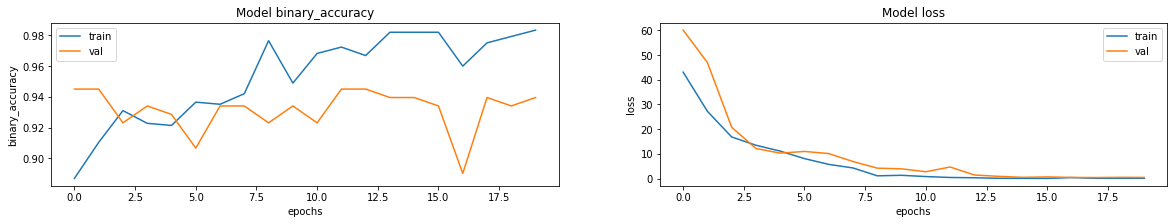

In [11]:
plot_history(hist)

# Unfreeze the base model and train the entire model

In [13]:
# Unfreeze the base_model.
base_model.trainable = True
# model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC(from_logits= True)],
)

epochs = 20
hist2 = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)
plot_history(hist2)

# Save Model

In [13]:
import datetime

cur_datetime = current_time = datetime.datetime.now().strftime('%Y_%m_%d')
save_path = f"ckp/xceptionNet/{cur_datetime}"
os.makedirs(save_path, exist_ok=True)

model.save_weights('{}/Pleural_effusion.h5'.format(save_path))
tf.saved_model.save(model, '{}/Pleural_effusion_best_tf'.format(save_path))


2022-05-24 17:43:08.435330: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/monib/Downloads/d/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: ckp/xceptionNet/2022_05_24/Pleural_effusion_best_tf/assets


# Load Model and Evaluate on val_dataset


In [14]:
model.load_weights('/media/monib/ext1/work2022/classification_keras/ckp/xceptionNet/2022_05_24/Pleural_effusion.h5')
print('Val evaluation', model.evaluate(val_dataset))

# TF model
# reloaded_model = tf.saved_model.load('{}/xcept_best_tf'.format(save_path))

2022-07-12 17:48:02.650690: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4580179968 exceeds 10% of free system memory.
2022-07-12 17:48:04.371919: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4580179968 exceeds 10% of free system memory.
/home/monib/Downloads/d/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'
2022-07-12 17:48:06.310991: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-12 17:48:06.337904: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz
2022-07-12 17:48:08.864688: I tensorflow/stream_executor/platform/default/

182/182 [==============================] - 17s 32ms/step - loss: 0.3820 - binary_accuracy: 0.9286 - auc: 0.8206
Val evaluation [0.3819752335548401, 0.9285714030265808, 0.8206394910812378]


# Single Image Path

In [13]:
ctx_path0 ="/media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/DICOM 파일 이신애/45/52134911/ㅇㅎㅅ.DCM"
ctx_path1 ="/media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/DICOM 파일 이신애/297/36582246/ㅇㅇㅅ.DCM"
png_path0 ="/media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/rgb_files_600/0/serial_no_45.png"
png_path1 ="/media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/rgb_files_600/1/serial_no_297.png"

img_array0 = get_array_from_dicom(ctx_path0)
img_array1 = get_array_from_dicom(ctx_path1)
print(img_array0.shape)

(1024, 1024, 3)


# Prediction on single image

In [15]:
y_pred0 = model.predict(np.expand_dims(img_array0, axis=0))
y_pred1 = model.predict(np.expand_dims(img_array1, axis=0))

print("prob y_pred0", y_pred0)
print("prob y_pred1", y_pred1)

# class scores
threshold = 0.5
print("class 0", np.where(y_pred0 > threshold, 1, 0))
print("class 1", np.where(y_pred1 > threshold, 1, 0))

prob y_pred0 [[1.3410755e-12]]
prob y_pred1 [[1.]]
class 0 [[0]]
class 1 [[1]]


# Predict on all data

In [14]:
def data2numpy2(data):
    normal_images = []
    normal_paths= []
    abnormal_images = []
    abnormal_paths = []

    #printing a few paths with corresponding serial number and labels
    for i in range(len(data[0]['x_ray_paths'])):
        try:
            label = data[0]['Pleural effusion'][i]
            if label == 0:

                img_arr = pydicom.dcmread(data[0]['x_ray_paths'][i]).pixel_array # has shape x,y
                img_norm, _, _ = preprocessor.normalize(img_arr)

                img_resized = preprocessor.resize(img_norm, (img_h, img_w))
                img_resized = np.stack((img_resized,)*3, axis=-1)

                normal_images.append(img_resized)
                normal_paths.append(data[0]['x_ray_paths'][i])
            else:
                img_arr = pydicom.dcmread(data[0]['x_ray_paths'][i]).pixel_array # has shape x,y
                img_norm, _, _ = preprocessor.normalize(img_arr)

                img_resized = preprocessor.resize(img_norm, (img_h, img_w))
                img_resized = np.stack((img_resized,)*3, axis=-1)

                abnormal_images.append(img_resized)
                abnormal_paths.append(data[0]['x_ray_paths'][i])
        except ValueError as ve:
            print(f"Value error at: {data[0]['x_ray_paths'][i]}")
    return normal_images, normal_paths, abnormal_images, abnormal_paths

In [15]:
norm_img, norm_pth, abnorm_img, abnorm_pth = data2numpy2(load_data(root_path))

cleaned up labels
Value error at: /media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/DICOM 파일 이신애/7/12109342/Chest PA/1.3.46.670589.26.802146.4.20150317.113311.347918.0.dcm
Value error at: /media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/DICOM 파일 이신애/9/12222935/1.3.46.670589.26.802065.4.20150304.162931.912466.0.dcm
Value error at: /media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/DICOM 파일 이신애/12/13538330/Chest PA/1.3.46.670589.26.802065.4.20201006.93033.669326.0.dcm
Value error at: /media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/DICOM 파일 이신애/14/14080074/Chest PA/1.3.46.670589.26.802065.4.20180102.110034.298247.0.dcm


In [16]:
# get all data with paths
threshold = 0.5
import csv
field = ["Path", "Prob", "Predicted Score"]

filename = "XceptionNet_Pleural_effusion.csv"

with open(filename, "a") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = field)
        writer.writeheader()
        for idx in range(len(norm_img)):
            y_pred= model.predict(np.expand_dims(norm_img[idx], axis=0))
            # class scores
            class_score = np.where(y_pred > threshold, 1, 0)
            data = [{"Path": norm_pth[idx].split('/')[8] + "[Normal (0)]" , "Prob": round(float(y_pred), 3), "Predicted Score":int(class_score)}]
            writer.writerows(data)
        for idx in range(len(abnorm_img)):
            y_pred= model.predict(np.expand_dims(abnorm_img[idx], axis=0))
            # class scores
            class_score = np.where(y_pred > threshold, 1, 0)
            data = [{"Path":abnorm_pth[idx].split('/')[8] + "[Abnormal (1)]", "Prob": round(float(y_pred), 3),"Predicted Score":int(class_score)}]
            writer.writerows(data)
        print("file saved!")

file saved!


# Save all heatmap

In [17]:
def save_all_heatmap(model, norm_img, norm_pth, abnorm_img, abnorm_pth, save_dir):

    model.layers[-1].activation = None

    last_conv_layer_name = "top_conv"

    for idx in range(len(norm_img)):

        img_name = "Serial_No" + norm_pth[idx].split('/')[8]

        # ----------- Convert to RGB Image for heatmap -----------
        img_norm = norm_img[idx][:, :, 0] * 255
        normal_dir = save_dir + "Normal(0)"
        os.makedirs(normal_dir, exist_ok=True)
        png_img = PIL_Image.fromarray(img_norm).convert('RGB')
        png_img.save(f"temp_img.png", 'png')

        heatmap = make_gradcam_heatmap(np.expand_dims(norm_img[idx] , axis=0), model, last_conv_layer_name)
        save_and_display_gradcam("temp_img.png", heatmap, cam_path=normal_dir + f"/{img_name}.jpg", alpha=0.2, only_save = True)

        # abnormal part
    for idx in range(len(abnorm_img)):
        img_name = "Serial_No" + abnorm_pth[idx].split('/')[8]

        # ----------- Convert to RGB Image for heatmap -----------
        img_abnorm = abnorm_img[idx][:, :, 0] * 255
        abnormal_dir = save_dir + "Abnormal(1)"
        os.makedirs(abnormal_dir, exist_ok=True)
        png_img = PIL_Image.fromarray(img_abnorm).convert('RGB')
        png_img.save(f"temp_img.png", 'png')

        heatmap = make_gradcam_heatmap(np.expand_dims(abnorm_img[idx], axis=0), model, last_conv_layer_name)
        save_and_display_gradcam("temp_img.png", heatmap, cam_path=abnormal_dir + f"/{img_name}.jpg", alpha=0.2, only_save = True)
    print("images save!")

save_dir = "/media/monib/ext1/work2022/Base_Dataset/chest_x_ray_snuh/hmp_Pleural_effusion/"


In [18]:
save_all_heatmap(model, norm_img, norm_pth, abnorm_img, abnorm_pth, save_dir=save_dir)

images save!


2022-05-23 16:57:43.825485: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


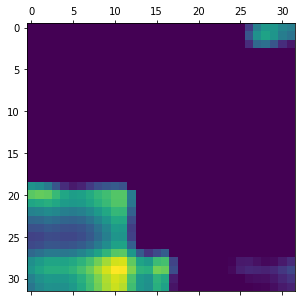

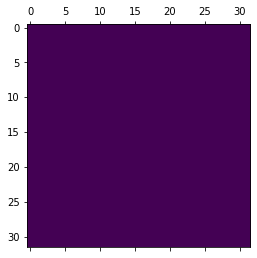

In [15]:
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
# preds = model.predict(np.expand_dims(img_array0, axis=0))
last_conv_layer_name = "top_conv"

# Generate class activation heatmap
heatmap0 = make_gradcam_heatmap(np.expand_dims(img_array0, axis=0), model, last_conv_layer_name)
heatmap1 = make_gradcam_heatmap(np.expand_dims(img_array1, axis=0), model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap0)
plt.matshow(heatmap1)
plt.show()

In [ ]:
heatmap0 = make_gradcam_heatmap(np.expand_dims(img_array0, axis=0), model, last_conv_layer_name)
heatmap1 = make_gradcam_heatmap(np.expand_dims(img_array1, axis=0), model, last_conv_layer_name)

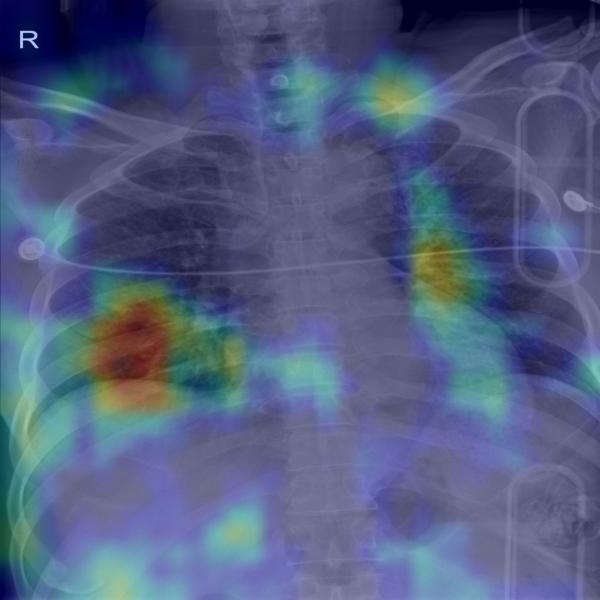

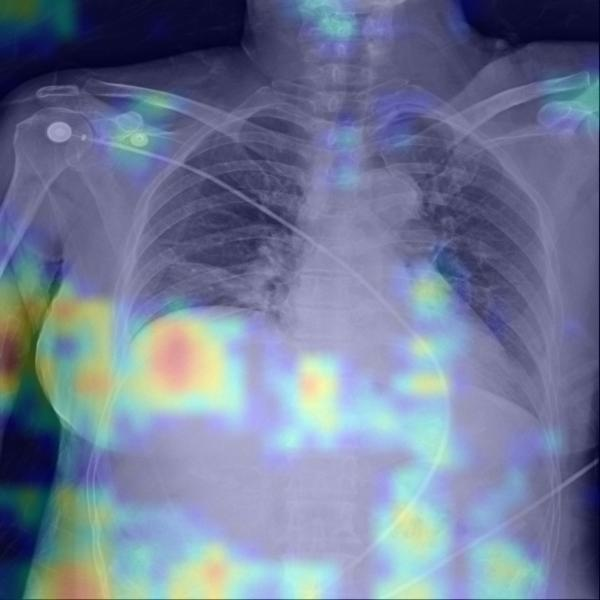

In [30]:
save_and_display_gradcam(png_path0, heatmap0)
save_and_display_gradcam(png_path1, heatmap1)

# Super Impose the heatmap on image

In [ ]:
save_and_display_gradcam(png_path0, heatmap0)
save_and_display_gradcam(png_path1, heatmap1)

# ROC Curve

Xception: ROC AUC=0.936


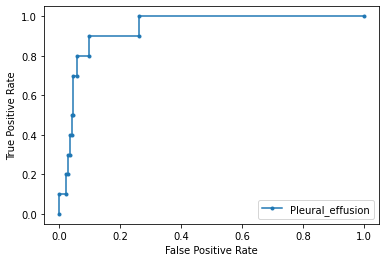

In [19]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

# calculate scores
y_pred = model.predict(x_val).ravel()
fpr, tpr, _ = roc_curve(y_val, y_pred)

lr_auc = roc_auc_score(y_val, y_pred)
# summarize scores
print('Xception: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label='Pleural_effusion')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Precision and recall

XceptionNet: auc=0.414


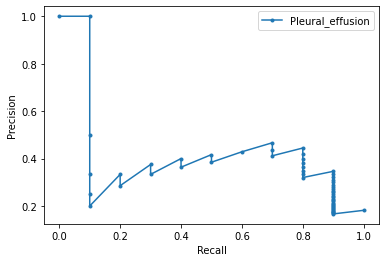

In [20]:
# predict probabilities
lr_precision, lr_recall, _ = precision_recall_curve(y_val, y_pred)
# lr_f1 = f1_score(y_val, y_pred)
lr_auc = auc(lr_recall, lr_precision)
# summarize scores
print('XceptionNet: auc=%.3f' % (lr_auc))
# plot the precision-recall curves
pyplot.plot(lr_recall, lr_precision, marker='.', label='Pleural_effusion')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()